In [10]:
#Importing the necessary libraries:
import cv2
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import os
from sklearn.model_selection import cross_val_score

In [11]:
#Initializing the values needed for all the image files
normaldir = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal'
tbdir = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis'
images = []
labels = []
imagesize = 224

In [12]:
#Storing all the image directories in the 'images' array and corresponding them to either 1 for TB images or 0 for normal images.
for x in os.listdir(normaldir):
    imagedir = os.path.join(normaldir, x)
    image = cv2.imread(imagedir, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (imagesize, imagesize))
    images.append(image)
    labels.append(0)
    
for y in os.listdir(tbdir):
    imagedir = os.path.join(tbdir, y)
    image = cv2.imread(imagedir, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (imagesize, imagesize))
    images.append(image)
    labels.append(1)

In [13]:
#Converting to NumPy arrays since they have more features than regular lists
images = np.array(images)
labels = np.array(labels)

#Splitting the images and labels into training and testing sets, then normalizing the values within them for computational efficiency (from 0-255 scale to 0-1 scale)
imagetrain, imagetest, label_train, label_test = train_test_split(images, labels, test_size=0.3, random_state=42)
train_img = (imagetrain.astype('float32')) / 255.0
test_img = (imagetest.astype('float32')) / 255.0

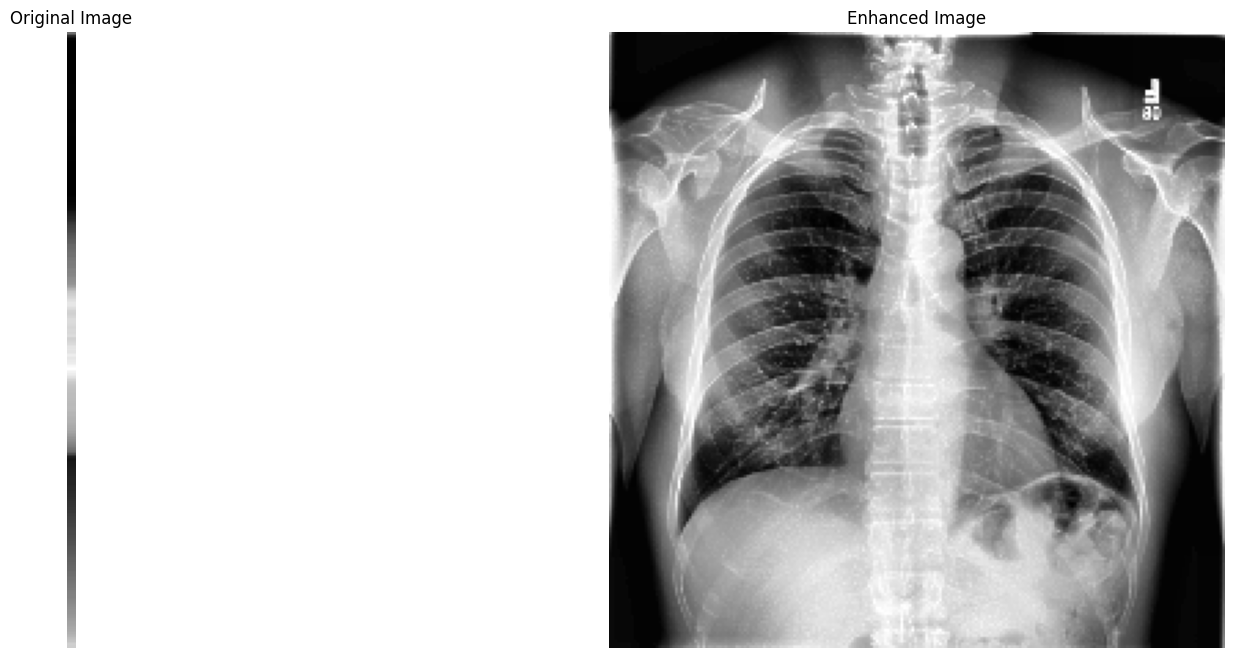

In [14]:
train2 = []  # This will store the enhanced images and their labels
for idx, image in enumerate(train_img):
    label = label_train[idx]  # Extract the corresponding label
    
    # Split the image into its R, G, and B channels
    b, g, r = cv2.split(image)

    # Convert each channel to 8-bit unsigned integer format if necessary
    b = cv2.normalize(b, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    g = cv2.normalize(g, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    r = cv2.normalize(r, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Apply CLAHE to each channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(6, 6))
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)

    # Merge the channels back into a single RGB image
    enhanced_image = cv2.merge([b, g, r])

    # Create a high-pass filter by subtracting a low-pass filter from the original
    low_pass = cv2.boxFilter(enhanced_image, ddepth=-1, ksize=(3, 3))
    high_pass = cv2.subtract(enhanced_image, low_pass)

    # Combine the high-pass filter with the original image to enhance edges
    enhanced_image = cv2.add(enhanced_image, high_pass)

    # Apply Canny edge detection
    feature = cv2.Canny(enhanced_image, 250, 300, apertureSize=3)
    
    # Apply morphological operations to remove noise
    kernel = np.ones((3, 3), np.uint8)
    feature_cleaned = cv2.morphologyEx(feature, cv2.MORPH_OPEN, kernel)
    
    # Convert the single-channel Canny result to 3 channels
    feature_rgb = cv2.cvtColor(feature_cleaned, cv2.COLOR_GRAY2BGR)

    # Add the Canny edges back to the enhanced RGB image
    final_output = cv2.add(enhanced_image, feature_rgb)

    # Save the final enhanced image with its label in train2
    train2.append([final_output, label])

# Example: Display an original and enhanced image side by side
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
if len(train_img[0][0].shape) == 3:
    plt.imshow(cv2.cvtColor(train_img[0][0], cv2.COLOR_BGR2RGB))
else:
    plt.imshow(train_img[0][0], cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
if len(train2[0][0].shape) == 3:
    plt.imshow(cv2.cvtColor(train2[0][0], cv2.COLOR_BGR2RGB))
else:
    plt.imshow(train2[0][0], cmap='gray')
plt.title('Enhanced Image')
plt.axis('off')

plt.show()

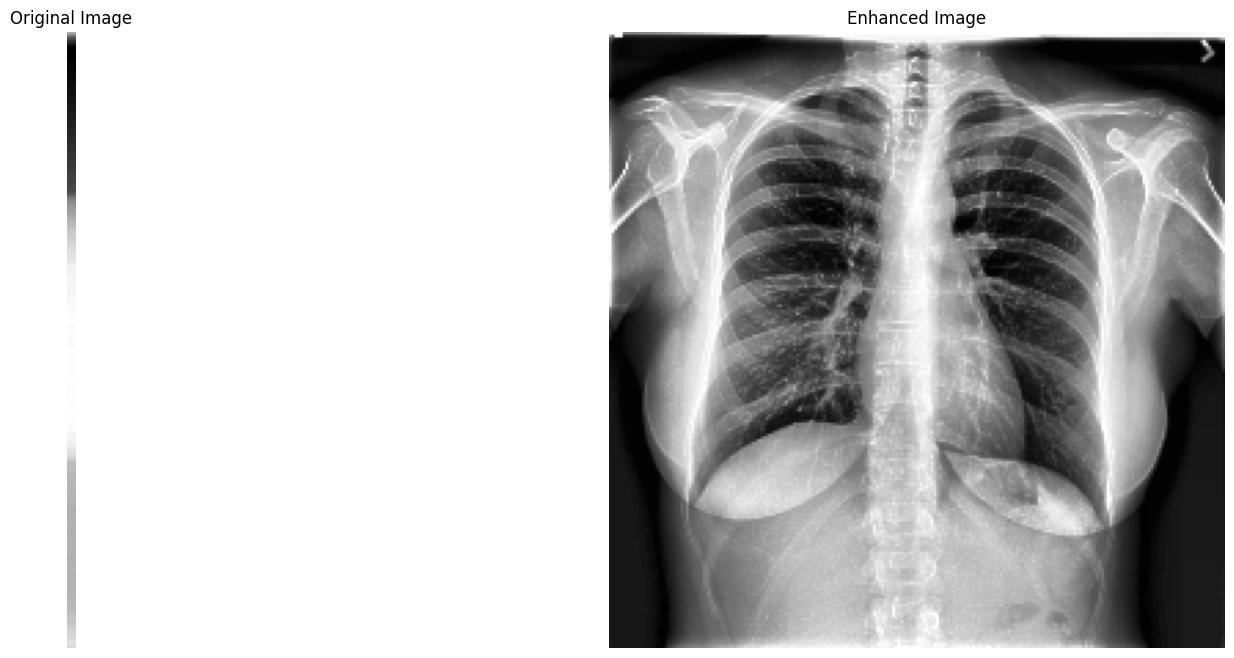

In [15]:
test2 = []  # This will store the enhanced images and their labels
for idx, image in enumerate(test_img):
    label = label_test[idx]  # Extract the corresponding label
    
    # Split the image into its R, G, and B channels
    b, g, r = cv2.split(image)

    # Convert each channel to 8-bit unsigned integer format if necessary
    b = cv2.normalize(b, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    g = cv2.normalize(g, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    r = cv2.normalize(r, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Apply CLAHE to each channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(6, 6))
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)

    # Merge the channels back into a single RGB image
    enhanced_image = cv2.merge([b, g, r])

    # Create a high-pass filter by subtracting a low-pass filter from the original
    low_pass = cv2.boxFilter(enhanced_image, ddepth=-1, ksize=(3, 3))
    high_pass = cv2.subtract(enhanced_image, low_pass)

    # Combine the high-pass filter with the original image to enhance edges
    enhanced_image = cv2.add(enhanced_image, high_pass)

    # Apply Canny edge detection
    feature = cv2.Canny(enhanced_image, 250, 300, apertureSize=3)
    
    # Apply morphological operations to remove noise
    kernel = np.ones((3, 3), np.uint8)
    feature_cleaned = cv2.morphologyEx(feature, cv2.MORPH_OPEN, kernel)
    
    # Convert the single-channel Canny result to 3 channels
    feature_rgb = cv2.cvtColor(feature_cleaned, cv2.COLOR_GRAY2BGR)

    # Add the Canny edges back to the enhanced RGB image
    final_output = cv2.add(enhanced_image, feature_rgb)

    # Save the final enhanced image with its label in train2
    test2.append([final_output, label])

# Example: Display an original and enhanced image side by side
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
if len(test_img[0][0].shape) == 3:
    plt.imshow(cv2.cvtColor(test_img[0][0], cv2.COLOR_BGR2RGB))
else:
    plt.imshow(test_img[0][0], cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
if len(test2[0][0].shape) == 3:
    plt.imshow(cv2.cvtColor(test2[0][0], cv2.COLOR_BGR2RGB))
else:
    plt.imshow(test2[0][0], cmap='gray')
plt.title('Enhanced Image')
plt.axis('off')

plt.show()

In [16]:
train_img=[]
i=1
for idx, image in enumerate(train_img):
    label = y_train[idx]  # Extract the label
    
    train_img.append([image, label])
enhanced_train_img=train2

train_img.extend(enhanced_train_img)

In [17]:
test_img=[]
i=1
for idx, image in enumerate(test_img):
    label = y_test[idx]  # Extract the label
    
    test_img.append([image, label])
enhanced_test_img=test2
test_img.extend(enhanced_test_img)

In [18]:
# #Flattening the image array into 2D (making it [2940 images] x [all the pixels of the image in just one 1D array]) to be suitable for SMOTE oversampling
# imagetrain = imagetrain.reshape(num_images, (imagesize*imagesize*3))

# #Performing oversampling
# smote = SMOTE(random_state=42)
# imagetrain, labeltrain = smote.fit_resample(imagetrain, labeltrain)

# #Unflattening the images now to use them for convolutional neural network (4914 images of 256x256 size, with 1 color channel (grayscale, as compared to RGB with 3 color channels))
# imagetrain = imagetrain.reshape(-1, imagesize, imagesize, 3)
# print(imagetrain.shape)

In [19]:
#Classes balanced - equal counts of each label
# print(np.unique(labeltrain, return_counts=True))

In [20]:
image_train = []
label_train = []

image_val = []
label_val = []

image_test = []
label_test = []

for feature, label in train_img:
    image_train.append(feature)
    label_train.append(label)

for feature, label in test_img:
    image_test.append(feature)
    label_test.append(label)

In [21]:
import numpy as np
image_train=np.array(image_train)
label_train=np.array(label_train)
image_test=np.array(image_test)
label_test=np.array(label_test)

In [22]:
img_size=224
image_train = image_train.reshape(-1, img_size, img_size, 3)
image_test = image_test.reshape(-1, img_size, img_size, 3)

In [23]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# VGG16

In [24]:
#Importing the necessary libraries
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [25]:
from keras.applications.vgg16 import VGG16
conv_base=VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
conv_base.trainable = True

In [27]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from keras import Sequential
# Create the Sequential model and add the conv_base and FC layers
model = Sequential()
model.add(conv_base)
model.add(Flatten())

# Adding fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Optional: Adding dropout to prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Optional: Adding another dropout layer
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

In [29]:
#Compiling the model with parameters best suited for the task at hand:
model.compile(
    loss='binary_crossentropy', #Best for binary classification
    optimizer = keras.optimizers.Adam(learning_rate=0.001), #Good starting LR for dataset of this size
    metrics=['accuracy'], #Looking for accuracy
)

In [30]:
#Fitting the model, with the ReduceLROnPlateau callback added to it to reduce the learning rate to take smaller steps in increasing the accuracy whenever the learning rate plateaus (goes in the wrong direction)
#Doing this with patience=1, meaning it will perform this if it even plateaus for one epoch, since only 10 epochs are used
#factor=0.1 means that for every time the learning rate is reduced, it is reduced by a factor of 0.1 - it also won't go lower than 0.00001
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.00001, verbose=1)

#Fitting the model w/ the callback. ON VS CODE, batch size of 16 makes each epoch take around a minute in this case w/ good accuracy, making the whole training process 10 min, but on Kaggle it should take longer due to less computational resources:
history = model.fit(image_train, label_train, batch_size=32, epochs=10, verbose=2, callbacks = [reduce_lr],validation_split=0.2)

Epoch 1/10


I0000 00:00:1730735948.122579     130 service.cc:145] XLA service 0x5c32eb0f9e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730735948.122617     130 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730735948.122620     130 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730735987.791455     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74/74 - 107s - 1s/step - accuracy: 0.8036 - loss: 3.2118 - val_accuracy: 0.8367 - val_loss: 0.4187 - learning_rate: 0.0010
Epoch 2/10
74/74 - 30s - 409ms/step - accuracy: 0.8342 - loss: 0.4028 - val_accuracy: 0.8452 - val_loss: 0.2218 - learning_rate: 0.0010
Epoch 3/10
74/74 - 30s - 403ms/step - accuracy: 0.8737 - loss: 0.2699 - val_accuracy: 0.9116 - val_loss: 0.1789 - learning_rate: 0.0010
Epoch 4/10
74/74 - 30s - 402ms/step - accuracy: 0.9043 - loss: 0.2128 - val_accuracy: 0.9116 - val_loss: 0.2151 - learning_rate: 0.0010
Epoch 5/10
74/74 - 30s - 406ms/step - accuracy: 0.9218 - loss: 0.1861 - val_accuracy: 0.9609 - val_loss: 0.1154 - learning_rate: 0.0010
Epoch 6/10
74/74 - 30s - 405ms/step - accuracy: 0.9422 - loss: 0.1451 - val_accuracy: 0.9694 - val_loss: 0.0987 - learning_rate: 0.0010
Epoch 7/10
74/74 - 30s - 404ms/step - accuracy: 0.9435 - loss: 0.1462 - val_accuracy: 0.9762 - val_loss: 0.0820 - learning_rate: 0.0010
Epoch 8/10
74/74 - 30s - 406ms/step - accuracy: 0.9583 - loss

In [31]:
print("Loss of the model is - " , model.evaluate(image_test,label_test)[0])
print("Accuracy of the model is - " , model.evaluate(image_test,label_test)[1]*100 , "%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9865 - loss: 0.0627
Loss of the model is -  0.0767926573753357
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9865 - loss: 0.0627
Accuracy of the model is -  98.41269850730896 %


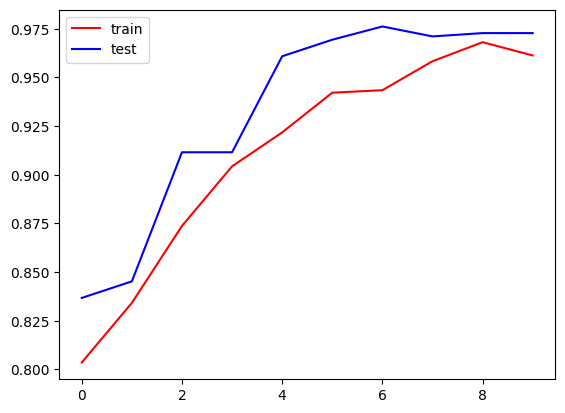

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

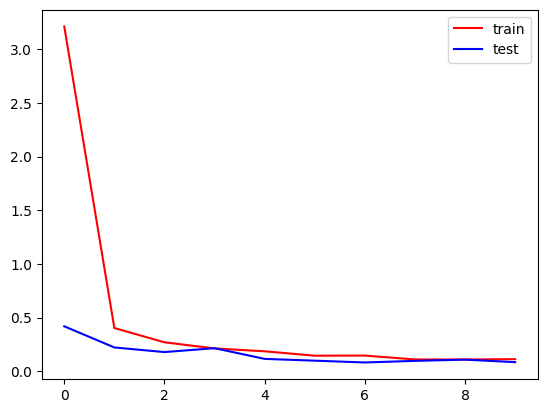

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

In [34]:
#Evaluating the data w/ multiple types of metrics
print('TESTING DATA:')
model.evaluate(image_test, label_test, batch_size=32, verbose=2)

print('ADVANCED TESTING METRICS:')
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(image_test, batch_size=32)
predicted_labels = (predictions > 0.5).astype('int32')
print(classification_report(label_test, predicted_labels))
print('----CONFUSION MATRICS----')
print(confusion_matrix(label_test, predicted_labels))

TESTING DATA:
40/40 - 5s - 117ms/step - accuracy: 0.9841 - loss: 0.0768
ADVANCED TESTING METRICS:
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1043
           1       0.95      0.96      0.95       217

    accuracy                           0.98      1260
   macro avg       0.97      0.98      0.97      1260
weighted avg       0.98      0.98      0.98      1260

----CONFUSION MATRICS----
[[1031   12]
 [   8  209]]


# ResNet-50


In [35]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau

conv_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

conv_base.trainable = True

model = Sequential([
    conv_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.00001, verbose=1)

history = model.fit(
    image_train, label_train,
    batch_size=32, epochs=15, verbose=2,
    callbacks=[reduce_lr],
    validation_split=0.2
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


I0000 00:00:1730736408.837897     128 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_29', 20 bytes spill stores, 20 bytes spill loads



74/74 - 118s - 2s/step - accuracy: 0.8954 - loss: 1.4720 - val_accuracy: 0.8367 - val_loss: 4579335.5000 - learning_rate: 0.0010
Epoch 2/15
74/74 - 22s - 298ms/step - accuracy: 0.9409 - loss: 0.7858 - val_accuracy: 0.9728 - val_loss: 3.9678 - learning_rate: 0.0010
Epoch 3/15
74/74 - 22s - 298ms/step - accuracy: 0.9804 - loss: 0.0754 - val_accuracy: 0.9337 - val_loss: 13.3681 - learning_rate: 0.0010
Epoch 4/15
74/74 - 22s - 291ms/step - accuracy: 0.9872 - loss: 0.0471 - val_accuracy: 0.9507 - val_loss: 1.0364 - learning_rate: 0.0010
Epoch 5/15
74/74 - 22s - 292ms/step - accuracy: 0.9902 - loss: 0.0307 - val_accuracy: 0.9541 - val_loss: 0.2105 - learning_rate: 0.0010
Epoch 6/15
74/74 - 22s - 295ms/step - accuracy: 0.9928 - loss: 0.0284 - val_accuracy: 0.9507 - val_loss: 0.9809 - learning_rate: 0.0010
Epoch 7/15

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
74/74 - 22s - 294ms/step - accuracy: 0.9847 - loss: 0.2892 - val_accuracy: 0.8350 - val_loss: 1.6562 

In [36]:
print("Loss of the model is - " , model.evaluate(image_test,label_test)[0])
print("Accuracy of the model is - " , model.evaluate(image_test,label_test)[1]*100 , "%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9901 - loss: 0.0498
Loss of the model is -  0.036291588097810745
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9901 - loss: 0.0498
Accuracy of the model is -  99.12698268890381 %


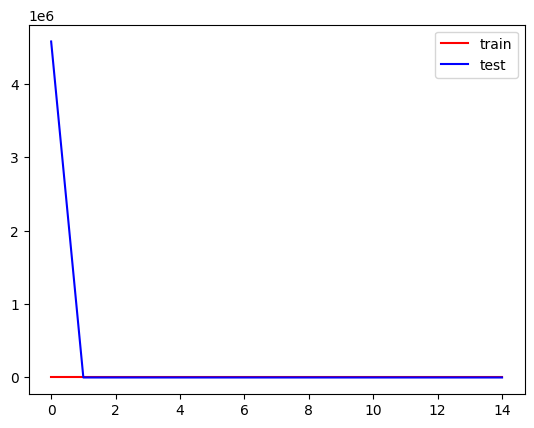

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

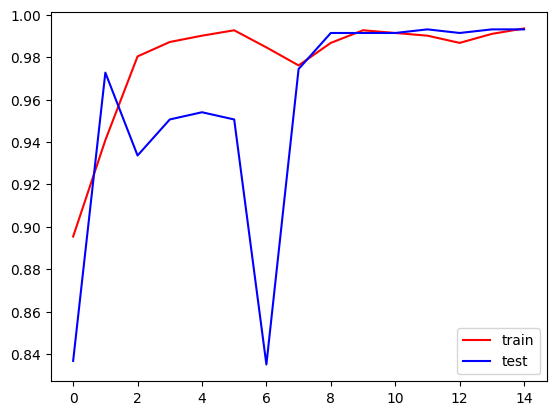

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

In [39]:
#Evaluating the data w/ multiple types of metrics
print('TESTING DATA:')
model.evaluate(image_test, label_test, batch_size=32, verbose=2)

print('ADVANCED TESTING METRICS:')
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(image_test, batch_size=32)
predicted_labels = (predictions > 0.5).astype('int32')
print(classification_report(label_test, predicted_labels))
print('----CONFUSION MATRICS----')
print(confusion_matrix(label_test, predicted_labels))

TESTING DATA:
40/40 - 3s - 77ms/step - accuracy: 0.9913 - loss: 0.0363
ADVANCED TESTING METRICS:
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1043
           1       0.99      0.96      0.97       217

    accuracy                           0.99      1260
   macro avg       0.99      0.98      0.98      1260
weighted avg       0.99      0.99      0.99      1260

----CONFUSION MATRICS----
[[1041    2]
 [   9  208]]


# DenseNet121

In [40]:
from keras.applications import DenseNet121

conv_base = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
conv_base.trainable = True

model = Sequential([
    conv_base,
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.00001, verbose=1)

history = model.fit(
    image_train, label_train,
    batch_size=32, epochs=15, verbose=2,
    callbacks=[reduce_lr],
    validation_split=0.2
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
74/74 - 275s - 4s/step - accuracy: 0.8827 - loss: 0.6789 - val_accuracy: 0.8367 - val_loss: 121.8064 - learning_rate: 0.0010
Epoch 2/15
74/74 - 22s - 299ms/step - accuracy: 0.9337 - loss: 0.2781 - val_accuracy: 0.8367 - val_loss: 75888.7031 - learning_rate: 0.0010
Epoch 3/15

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
74/74 - 22s - 295ms/step - accuracy: 0.9107 - loss: 0.9328 - val_accuracy: 0.8367 - val_loss: 71.1924 - learning_rate: 0.0010
Epoch 4/15

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
74/74 - 23s - 307ms/step - accuracy: 0.8737 - loss: 0.2658 - val_accuracy: 0.8929 - val_loss: 3.3204 - learning_rate: 1.0000e-04
Epoch 5/15

Epoch 5: ReduceLROnPlateau reducing learning rate to 1e-05.
74/74 - 22s - 291ms/step - accuracy: 0.8997 - loss: 0.2318 - val_accuracy: 0.9796 - val_loss: 0.1889 - learning_rate: 1.0000e-05
Epoch 6/15
74/74 - 22s - 294ms/step - a

In [41]:
print("Loss of the model is - " , model.evaluate(image_test,label_test)[0])
print("Accuracy of the model is - " , model.evaluate(image_test,label_test)[1]*100 , "%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9873 - loss: 0.0590
Loss of the model is -  0.04642883688211441
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9873 - loss: 0.0590
Accuracy of the model is -  98.96825551986694 %


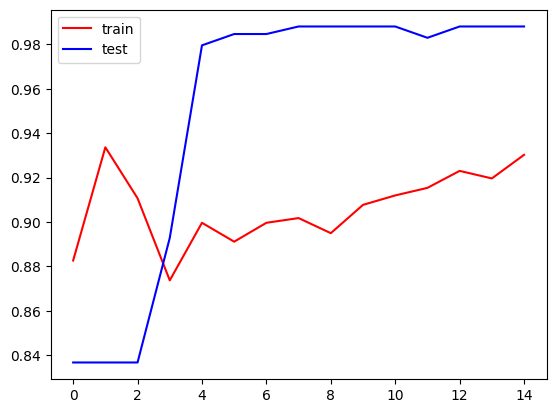

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

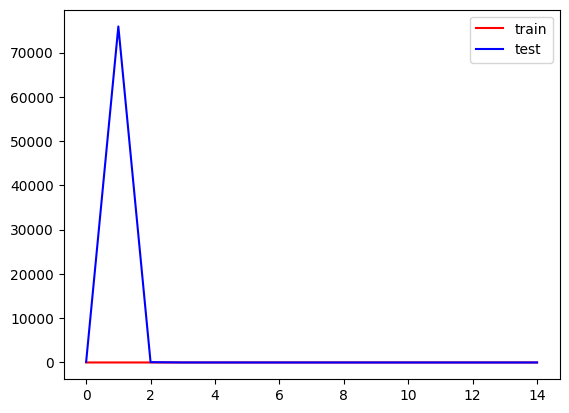

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

In [44]:
#Evaluating the data w/ multiple types of metrics
print('TESTING DATA:')
model.evaluate(image_test, label_test, batch_size=32, verbose=2)

print('ADVANCED TESTING METRICS:')
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(image_test, batch_size=32)
predicted_labels = (predictions > 0.5).astype('int32')
print(classification_report(label_test, predicted_labels))
print('----CONFUSION MATRICS----')
print(confusion_matrix(label_test, predicted_labels))

TESTING DATA:
40/40 - 3s - 69ms/step - accuracy: 0.9897 - loss: 0.0464
ADVANCED TESTING METRICS:
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 270ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1043
           1       1.00      0.94      0.97       217

    accuracy                           0.99      1260
   macro avg       0.99      0.97      0.98      1260
weighted avg       0.99      0.99      0.99      1260

----CONFUSION MATRICS----
[[1043    0]
 [  13  204]]


# InceptionV3

In [45]:
from keras.applications import InceptionV3

conv_base = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
conv_base.trainable = True

model = Sequential([
    conv_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.00001, verbose=1)

history = model.fit(
    image_train, label_train,
    batch_size=32, epochs=10, verbose=2,
    callbacks=[reduce_lr],
    validation_split=0.2
)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
74/74 - 145s - 2s/step - accuracy: 0.8648 - loss: 0.9951 - val_accuracy: 0.8929 - val_loss: 3.0309 - learning_rate: 0.0010
Epoch 2/10
74/74 - 17s - 230ms/step - accuracy: 0.9141 - loss: 0.3457 - val_accuracy: 0.6276 - val_loss: 6.6808 - learning_rate: 0.0010
Epoch 3/10
74/74 - 17s - 233ms/step - accuracy: 0.9260 - loss: 0.2464 - val_accuracy: 0.8912 - val_loss: 1.2419 - learning_rate: 0.0010
Epoch 4/10
74/74 - 17s - 228ms/step - accuracy: 0.9545 - loss: 0.1296 - val_accuracy: 0.9388 - val_loss: 0.4635 - learning_rate: 0.0010
Epoch 5/10

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
74/74 - 17s - 225ms/step - accuracy: 0.9371 - loss: 0.1861 - val_accuracy: 0.9235 - val_loss: 1.4758 - learning_rate: 0.0010
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
74/74 - 17s - 226ms/step - accuracy: 0.9247 - loss: 0.2453 - val_accuracy: 0.8622 - val_loss: 1.9427 - l

In [46]:
print("Loss of the model is - " , model.evaluate(image_test,label_test)[0])
print("Accuracy of the model is - " , model.evaluate(image_test,label_test)[1]*100 , "%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9732 - loss: 0.1198
Loss of the model is -  0.09845377504825592
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9732 - loss: 0.1198
Accuracy of the model is -  98.01587462425232 %


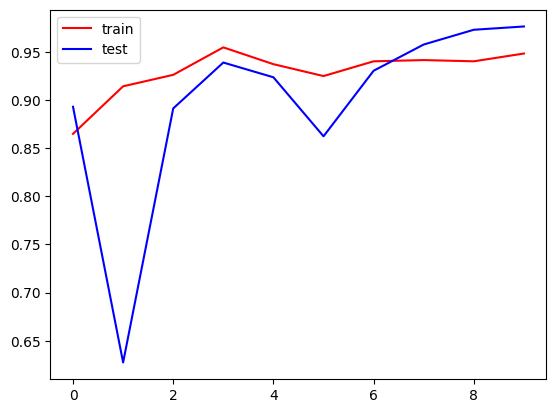

In [47]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

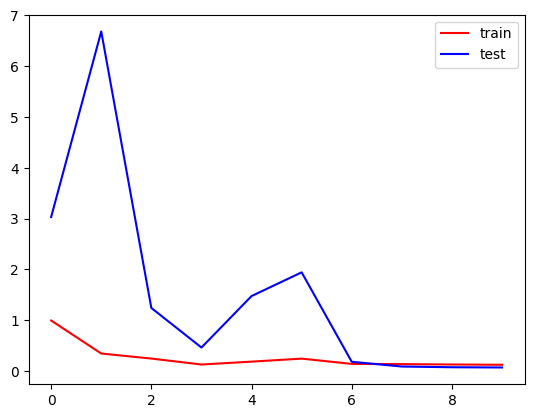

In [48]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

In [49]:
#Evaluating the data w/ multiple types of metrics
print('TESTING DATA:')
model.evaluate(image_test, label_test, batch_size=32, verbose=2)

print('ADVANCED TESTING METRICS:')
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(image_test, batch_size=32)
predicted_labels = (predictions > 0.5).astype('int32')
print(classification_report(label_test, predicted_labels))
print('----CONFUSION MATRICS----')
print(confusion_matrix(label_test, predicted_labels))

TESTING DATA:
40/40 - 2s - 56ms/step - accuracy: 0.9802 - loss: 0.0985
ADVANCED TESTING METRICS:
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1043
           1       0.98      0.90      0.94       217

    accuracy                           0.98      1260
   macro avg       0.98      0.95      0.96      1260
weighted avg       0.98      0.98      0.98      1260

----CONFUSION MATRICS----
[[1039    4]
 [  21  196]]


# Lenet-5

In [50]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

model = Sequential([
    Conv2D(6, (5, 5), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.00001, verbose=1)

history = model.fit(
    image_train, label_train,
    batch_size=32, epochs=10, verbose=2,
    callbacks=[reduce_lr],
    validation_split=0.2
)


Epoch 1/10
74/74 - 9s - 116ms/step - accuracy: 0.8525 - loss: 46.1590 - val_accuracy: 0.9354 - val_loss: 0.1598 - learning_rate: 0.0010
Epoch 2/10
74/74 - 1s - 16ms/step - accuracy: 0.9762 - loss: 0.0690 - val_accuracy: 0.9660 - val_loss: 0.1526 - learning_rate: 0.0010
Epoch 3/10
74/74 - 1s - 16ms/step - accuracy: 0.9983 - loss: 0.0134 - val_accuracy: 0.9626 - val_loss: 0.1412 - learning_rate: 0.0010
Epoch 4/10
74/74 - 1s - 16ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9660 - val_loss: 0.1276 - learning_rate: 0.0010
Epoch 5/10

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
74/74 - 1s - 16ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9728 - val_loss: 0.1210 - learning_rate: 0.0010
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
74/74 - 1s - 16ms/step - accuracy: 1.0000 - loss: 4.7570e-04 - val_accuracy: 0.9728 - val_loss: 0.1232 - learning_rate: 1.0000e-04
Epoch 7/10

Epoch 7: ReduceLRO

In [51]:
print("Loss of the model is - " , model.evaluate(image_test,label_test)[0])
print("Accuracy of the model is - " , model.evaluate(image_test,label_test)[1]*100 , "%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9670 - loss: 0.2989
Loss of the model is -  0.24442148208618164
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9670 - loss: 0.2989
Accuracy of the model is -  96.98412418365479 %


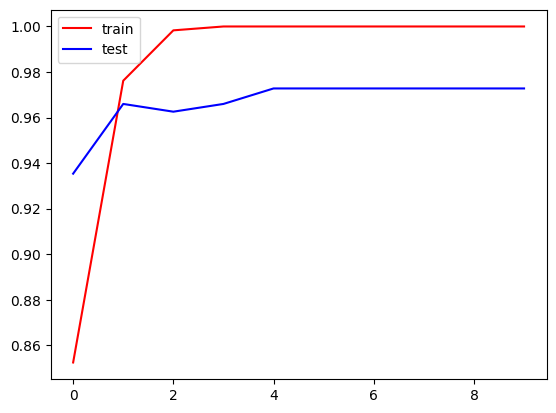

In [52]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

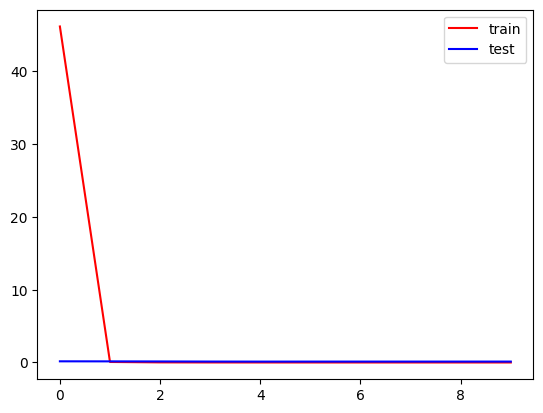

In [53]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

In [54]:
#Evaluating the data w/ multiple types of metrics
print('TESTING DATA:')
model.evaluate(image_test, label_test, batch_size=32, verbose=2)

print('ADVANCED TESTING METRICS:')
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(image_test, batch_size=32)
predicted_labels = (predictions > 0.5).astype('int32')
print(classification_report(label_test, predicted_labels))
print('----CONFUSION MATRICS----')
print(confusion_matrix(label_test, predicted_labels))

TESTING DATA:
40/40 - 0s - 6ms/step - accuracy: 0.9698 - loss: 0.2444
ADVANCED TESTING METRICS:
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1043
           1       0.96      0.86      0.91       217

    accuracy                           0.97      1260
   macro avg       0.97      0.93      0.94      1260
weighted avg       0.97      0.97      0.97      1260

----CONFUSION MATRICS----
[[1035    8]
 [  30  187]]


# VGG-19

In [55]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
conv_base.trainable =True
model = Sequential([
    conv_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.00001, verbose=1)

history = model.fit(
    image_train, label_train,
    batch_size=32, epochs=10, verbose=2,
    callbacks=[reduce_lr],
    validation_split=0.2
)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
74/74 - 51s - 691ms/step - accuracy: 0.7895 - loss: 4.4947 - val_accuracy: 0.8367 - val_loss: 0.4310 - learning_rate: 0.0010
Epoch 2/10
74/74 - 35s - 479ms/step - accuracy: 0.8185 - loss: 0.4985 - val_accuracy: 0.8367 - val_loss: 0.3533 - learning_rate: 0.0010
Epoch 3/10
74/74 - 36s - 484ms/step - accuracy: 0.8393 - loss: 0.3208 - val_accuracy: 0.8469 - val_loss: 0.2268 - learning_rate: 0.0010
Epoch 4/10
74/74 - 35s - 479ms/step - accuracy: 0.8737 - loss: 0.2717 - val_accuracy: 0.8367 - val_loss: 0.3674 - learning_rate: 0.0010
Epoch 5/10
74/74 - 36s - 480ms/step - accuracy: 0.8784 - loss: 0.2733 - val_accuracy: 0.9167 - val_loss: 0.1890 - learning_rate: 0.0010
Epoch 6/10
74/74 - 36s - 483ms/step - accuracy: 0.9349 - loss: 0.1627 - val_accuracy: 0.9677 - val_loss: 0.0915 - learning_rate: 0.0010
Epoch 7/10
74/74 - 35s - 479ms/step - accuracy: 0.9371 - loss: 0.1519 - val_accuracy: 0.9711 - val_loss: 0.0859 - learning_rate: 0.00

In [56]:
print("Loss of the model is - " , model.evaluate(image_test,label_test)[0])
print("Accuracy of the model is - " , model.evaluate(image_test,label_test)[1]*100 , "%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9834 - loss: 0.0516
Loss of the model is -  0.05515935271978378
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9834 - loss: 0.0516
Accuracy of the model is -  98.09523820877075 %


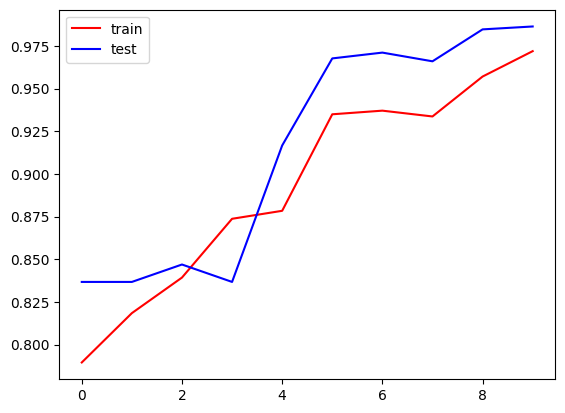

In [57]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

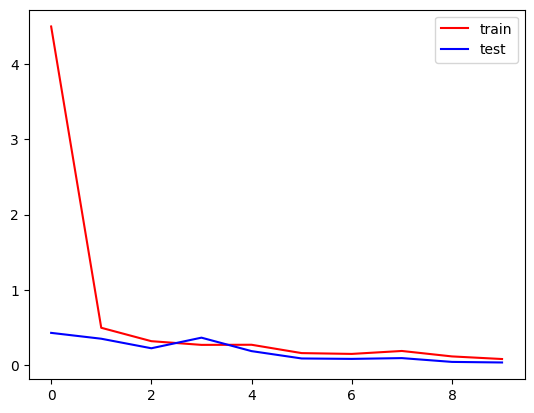

In [58]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

In [59]:
#Evaluating the data w/ multiple types of metrics
print('TESTING DATA:')
model.evaluate(image_test, label_test, batch_size=32, verbose=2)

print('ADVANCED TESTING METRICS:')
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(image_test, batch_size=32)
predicted_labels = (predictions > 0.5).astype('int32')
print(classification_report(label_test, predicted_labels))
print('----CONFUSION MATRICS----')
print(confusion_matrix(label_test, predicted_labels))

TESTING DATA:
40/40 - 6s - 138ms/step - accuracy: 0.9810 - loss: 0.0552
ADVANCED TESTING METRICS:
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1043
           1       0.97      0.92      0.94       217

    accuracy                           0.98      1260
   macro avg       0.98      0.96      0.97      1260
weighted avg       0.98      0.98      0.98      1260

----CONFUSION MATRICS----
[[1037    6]
 [  18  199]]
